# GRU + BiLSTM ensemble model

## create at 1:19 4/Jun/25

### 1. 匯入套件 

In [1]:
import pandas as pd
import re, contractions
import numpy as np
import torch
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import LabelEncoder
import nltk
from gensim.models import KeyedVectors
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from gensim.scripts.glove2word2vec import glove2word2vec
import os

### 2. 下載必要資源（只需第一次執行）

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-d

True

### 3. 初始化工具

In [3]:
stop_words = set(stopwords.words('english')) - {"not", "no", "never"}
encoder = LabelEncoder()
tokenizer = TweetTokenizer(preserve_case=False)
np.random.seed(42)

### 4. 定義前處理函數 

In [4]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"[^a-zA-Z \s]", '', text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

### 5. 讀取資料集

In [5]:
df_train = pd.read_csv("Corona_NLP_train.csv", encoding='latin_1')
df_test = pd.read_csv("Corona_NLP_test.csv", encoding='latin_1')
df_train, df_val = train_test_split(df_train, test_size=0.2, stratify=df_train["Sentiment"], random_state=42)

### 6. 套用前處理

In [6]:
df_train["CleanedTweet"] = df_train["OriginalTweet"].apply(clean_text)
df_val["CleanedTweet"] = df_val["OriginalTweet"].apply(clean_text)
df_test["CleanedTweet"] = df_test["OriginalTweet"].apply(clean_text)

### 7. 處理情緒標籤

In [7]:
df_train["SentimentEncoded"] = encoder.fit_transform(df_train["Sentiment"])
df_val["SentimentEncoded"] = encoder.transform(df_val["Sentiment"])
df_test["SentimentEncoded"] = encoder.transform(df_test["Sentiment"])

### 8. 分詞與詞彙表

In [8]:
def tokenize_text(text):
    return tokenizer.tokenize(text)

train_tokens = [tokenize_text(text) for text in df_train["CleanedTweet"]]
val_tokens = [tokenize_text(text) for text in df_val["CleanedTweet"]]
test_tokens = [tokenize_text(text) for text in df_test["CleanedTweet"]]

def build_manual_vocab(token_list):
    token_counts = Counter()
    for tokens in token_list:
        token_counts.update(tokens)
    sorted_tokens = [token for token, count in token_counts.items()]
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for i, token in enumerate(sorted_tokens):
        vocab[token] = i + 2
    return vocab

vocab = build_manual_vocab(train_tokens)

### 9. 載入GloVe詞向量

In [9]:
glove_input_file = r'C:\Users\skych\glove.twitter.27B\glove.twitter.27B.100d.txt'
word2vec_output_file = r'C:\Users\skych\glove.twitter.27B\glove.twitter.27B.100d.word2vec.txt'

if not os.path.exists(word2vec_output_file):
    print("🔄 轉換 GloVe → Word2Vec 格式...")
    glove2word2vec(glove_input_file, word2vec_output_file)

w2v_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((len(vocab), embedding_dim))

In [10]:
for word, idx in vocab.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    elif word == "<PAD>":
        continue
    elif word == "<UNK>":
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    else:
        embedding_matrix[idx] = embedding_matrix[vocab["<UNK>"]]

### 10. 轉換為數字序列與Padding

In [11]:
def tokens_to_indices_manual(tokens, vocab):
    return torch.tensor([vocab.get(token, vocab["<UNK>"]) for token in tokens], dtype=torch.long)

train_indices = [tokens_to_indices_manual(tokens, vocab) for tokens in train_tokens]
val_indices = [tokens_to_indices_manual(tokens, vocab) for tokens in val_tokens]
test_indices = [tokens_to_indices_manual(tokens, vocab) for tokens in test_tokens]

def manual_padding(indices_list, pad_value, max_len):
    padded_sequences = []
    pad_tensor = torch.tensor([pad_value], dtype=torch.long)
    for seq in indices_list:
        if len(seq) > max_len:
            seq = seq[:max_len]
        padding_needed = max_len - len(seq)
        padding = pad_tensor.repeat(padding_needed)
        padded_seq = torch.cat((seq, padding))
        padded_sequences.append(padded_seq)
    return torch.stack(padded_sequences)

In [12]:
BEST_MAX_LEN = 50
pad_value = vocab["<PAD>"]
train_padded = manual_padding(train_indices, pad_value, BEST_MAX_LEN)
val_padded = manual_padding(val_indices, pad_value, BEST_MAX_LEN)
test_padded = manual_padding(test_indices, pad_value, BEST_MAX_LEN)

train_labels = torch.tensor(df_train["SentimentEncoded"].values, dtype=torch.long)
val_labels = torch.tensor(df_val["SentimentEncoded"].values, dtype=torch.long)
test_labels = torch.tensor(df_test["SentimentEncoded"].values, dtype=torch.long)

### 11. 定義DataLoader

In [13]:
BEST_BATCH_SIZE = 256  # 給定值
train_loader = DataLoader(TensorDataset(train_padded, train_labels), batch_size=BEST_BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(TensorDataset(val_padded, val_labels), batch_size=BEST_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(test_padded, test_labels), batch_size=BEST_BATCH_SIZE, shuffle=False)

### 12. 定義GRU模型

In [47]:
# 定義 GRUClassifier（移除 LayerNorm）
class GRUClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, padding_idx, num_layers, dropout, pooling, activation):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), 
                                                      padding_idx=padding_idx, freeze=False)
        self.gru = nn.GRU(input_size=self.embedding.embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.Tanh() if activation == 'tanh' else nn.ReLU()
        # 移除 LayerNorm
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        gru_out, _ = self.gru(embedded)  # [batch_size, seq_len, hidden_dim * 2]
        
        # 統一使用 max 池化
        pooled = torch.max(gru_out, dim=1)[0]  # [batch_size, hidden_dim * 2]

        pooled = self.dropout(pooled)
        pooled = self.activation(pooled)
        # 移除 LayerNorm
        pooled = self.layer_norm(pooled)
        logits = self.fc(pooled)  # [batch_size, output_dim]
        return logits

### 13. 定義BiLSTM模型

In [15]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=64, output_dim=5, padding_idx=0, num_layers=2, dropout=0.55, pooling='max', activation='tanh'):
        super(BiLSTMClassifier, self).__init__()
        num_embeddings, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.pooling = pooling
        self.activation = nn.Tanh() if activation == 'tanh' else nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        output, (h_n, c_n) = self.lstm(x)
        if self.pooling == 'max':
            pooled, _ = output.max(dim=1)
        elif self.pooling == 'mean':
            pooled = output.mean(dim=1)
        elif self.pooling == 'hidden':
            pooled = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            raise ValueError(f"Unknown pooling: {self.pooling}")
        if self.activation:
            pooled = self.activation(pooled)
        x = self.dropout(pooled)
        x = self.norm(x)
        out = self.fc(x)
        return out

### 14. 定義集成模型

In [16]:
class EnsembleClassifier(nn.Module):
    def __init__(self, gru_model, lstm_model, weight_gru=0.55):
        super(EnsembleClassifier, self).__init__()
        self.gru_model = gru_model
        self.lstm_model = lstm_model
        self.weight_gru = weight_gru
        self.weight_lstm = 1.0 - weight_gru

    def forward(self, x):
        gru_output = self.gru_model(x)
        lstm_output = self.lstm_model(x)
        gru_probs = torch.softmax(gru_output, dim=1)
        lstm_probs = torch.softmax(lstm_output, dim=1)
        ensemble_probs = self.weight_gru * gru_probs + self.weight_lstm * lstm_probs
        return ensemble_probs

### 15. 訓練與評估函數

In [17]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct = 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device, title="Evaluation"):
    model.eval()
    total_loss, total_correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / len(loader.dataset)
    print(f"\n{title} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=encoder.classes_))
    return avg_loss, accuracy

### 16. 訓練流程

In [18]:
pip install torchinfo

In [48]:
import torch
from torchinfo import summary # 確保你已導入 torchinfo

# ... (你的其他變量定義，如 device, EPOCHS_FINAL, BEST_LR, BEST_DROPOUT, BEST_POOLING, BEST_NUM_LAYERS,
# BEST_HIDDEN_DIM, patience, weight_gru, factor, embedding_matrix, encoder, vocab,
# GRUClassifier, BiLSTMClassifier 等) ...

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS_FINAL = 20
BEST_LR = 0.0003
BEST_DROPOUT = 0.3
BEST_POOLING = 'max'
BEST_NUM_LAYERS = 2
BEST_HIDDEN_DIM = 256
patience = 3
weight_gru = 0.3
factor = 0.5

# 初始化模型
gru_model = GRUClassifier(
    embedding_matrix=embedding_matrix,
    hidden_dim=BEST_HIDDEN_DIM,
    output_dim=len(encoder.classes_),
    padding_idx=vocab["<PAD>"],
    num_layers=BEST_NUM_LAYERS,
    dropout=BEST_DROPOUT,
    pooling=BEST_POOLING,
    activation='tanh'
).to(device)

lstm_model = BiLSTMClassifier(
    embedding_matrix=embedding_matrix,
    hidden_dim=BEST_HIDDEN_DIM,
    output_dim=len(encoder.classes_),
    padding_idx=vocab["<PAD>"],
    num_layers=BEST_NUM_LAYERS,
    dropout=BEST_DROPOUT,
    pooling=BEST_POOLING,
    activation='tanh'
).to(device)
    
# 使用 input_size 和 dtypes 來指定輸入形狀與型別，確保與模型輸入匹配
# 顯示 GRU 模型結構
print("\n🎯 GRU 模型結構：")
summary(gru_model, input_size=(1, BEST_MAX_LEN), dtypes=[torch.long], device=device.type)

print("\n🎯 BiLSTM 模型結構：")
summary(lstm_model, input_size=(1, BEST_MAX_LEN), device=device.type, dtypes=[torch.long])


🎯 GRU 模型結構：

🎯 BiLSTM 模型結構：


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMClassifier                         [1, 5]                    --
├─Embedding: 1-1                         [1, 50, 100]              4,205,800
├─LSTM: 1-2                              [1, 50, 512]              2,310,144
├─Tanh: 1-3                              [1, 512]                  --
├─Dropout: 1-4                           [1, 512]                  --
├─LayerNorm: 1-5                         [1, 512]                  1,024
├─Linear: 1-6                            [1, 5]                    2,565
Total params: 6,519,533
Trainable params: 6,519,533
Non-trainable params: 0
Total mult-adds (M): 119.72
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 26.08
Estimated Total Size (MB): 26.33

In [23]:
# 定義優化器和損失函數
criterion = nn.CrossEntropyLoss()
optimizer_gru = optim.Adam(gru_model.parameters(), lr=BEST_LR)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=BEST_LR)
scheduler_gru = optim.lr_scheduler.ReduceLROnPlateau(optimizer_gru, 'min', factor=factor, patience=patience)
scheduler_lstm = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lstm, 'min', factor=factor, patience=patience)

# 訓練 GRU 模型
train_losses_gru, val_losses_gru, val_accuracies_gru = [], [], []
best_val_loss_gru = float('inf')
patience_counter_gru = 0
for epoch in range(EPOCHS_FINAL):
    gru_model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_gru.zero_grad()
        outputs = gru_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_gru.step()
        train_loss += loss.item()
    train_losses_gru.append(train_loss / len(train_loader))

    gru_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = gru_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_losses_gru.append(val_loss / len(val_loader))
    val_accuracies_gru.append(correct / total)

    scheduler_gru.step(val_loss / len(val_loader))
    if val_loss < best_val_loss_gru:
        best_val_loss_gru = val_loss
        patience_counter_gru = 0
        torch.save(gru_model.state_dict(), 'best_gru_model.pth')
    else:
        patience_counter_gru += 1
        if patience_counter_gru >= patience:
            print(f"GRU Early stopping at epoch {epoch+1}")
            break

# 訓練 BiLSTM 模型
train_losses_lstm, val_losses_lstm, val_accuracies_lstm = [], [], []
best_val_loss_lstm = float('inf')
patience_counter_lstm = 0
for epoch in range(EPOCHS_FINAL):
    lstm_model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_lstm.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lstm.step()
        train_loss += loss.item()
    train_losses_lstm.append(train_loss / len(train_loader))

    lstm_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_losses_lstm.append(val_loss / len(val_loader))
    val_accuracies_lstm.append(correct / total)

    scheduler_lstm.step(val_loss / len(val_loader))
    if val_loss < best_val_loss_lstm:
        best_val_loss_lstm = val_loss
        patience_counter_lstm = 0
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
    else:
        patience_counter_lstm += 1
        if patience_counter_lstm >= patience:
            print(f"BiLSTM Early stopping at epoch {epoch+1}")
            break

# 顯示最後一個 epoch 的 score
print("\n🎯 GRU 模型最後一個 epoch 的結果：")
print(f"訓練損失: {train_losses_gru[-1]:.4f}")
print(f"驗證損失: {val_losses_gru[-1]:.4f}")
print(f"驗證準確率: {val_accuracies_gru[-1]:.4f}")

print("\n🎯 BiLSTM 模型最後一個 epoch 的結果：")
print(f"訓練損失: {train_losses_lstm[-1]:.4f}")
print(f"驗證損失: {val_losses_lstm[-1]:.4f}")
print(f"驗證準確率: {val_accuracies_lstm[-1]:.4f}")

GRU Early stopping at epoch 10
BiLSTM Early stopping at epoch 10

🎯 GRU 模型最後一個 epoch 的結果：
訓練損失: 0.3439
驗證損失: 0.8487
驗證準確率: 0.7476

🎯 BiLSTM 模型最後一個 epoch 的結果：
訓練損失: 0.3340
驗證損失: 0.9344
驗證準確率: 0.7392


### 17. 集成模型評估 

In [24]:
try:
    gru_model.load_state_dict(torch.load("best_gru_model.pt"))
    lstm_model.load_state_dict(torch.load("best_lstm_model.pt"))
except FileNotFoundError:
    print("Warning: Best model weights not found, using current model state.")
ensemble_model = EnsembleClassifier(gru_model, lstm_model, weight_gru=weight_gru).to(device)
val_loss, val_acc = evaluate(ensemble_model, val_loader, criterion, device, title="Ensemble Validation")


Ensemble Validation Classification Report:
                    precision    recall  f1-score   support

Extremely Negative       0.79      0.72      0.75      1096
Extremely Positive       0.83      0.70      0.76      1325
          Negative       0.68      0.74      0.71      1983
           Neutral       0.86      0.77      0.81      1543
          Positive       0.68      0.77      0.73      2285

          accuracy                           0.75      8232
         macro avg       0.77      0.74      0.75      8232
      weighted avg       0.75      0.75      0.75      8232



In [25]:
# 輸出最終參數與結果
best_params = {
    'dropout': BEST_DROPOUT,
    'num_layers': BEST_NUM_LAYERS,
    'hidden_dim': BEST_HIDDEN_DIM,
    'lr': BEST_LR,
    'weight_gru': weight_gru,
    'batch_size': BEST_BATCH_SIZE,
    'patience': patience
}
print(f"\nBest validation accuracy: {val_acc:.4f} with params: {best_params}")


Best validation accuracy: 0.7453 with params: {'dropout': 0.3, 'num_layers': 2, 'hidden_dim': 256, 'lr': 0.0003, 'weight_gru': 0.3, 'batch_size': 256, 'patience': 3}


### 18. 視覺化訓練過程

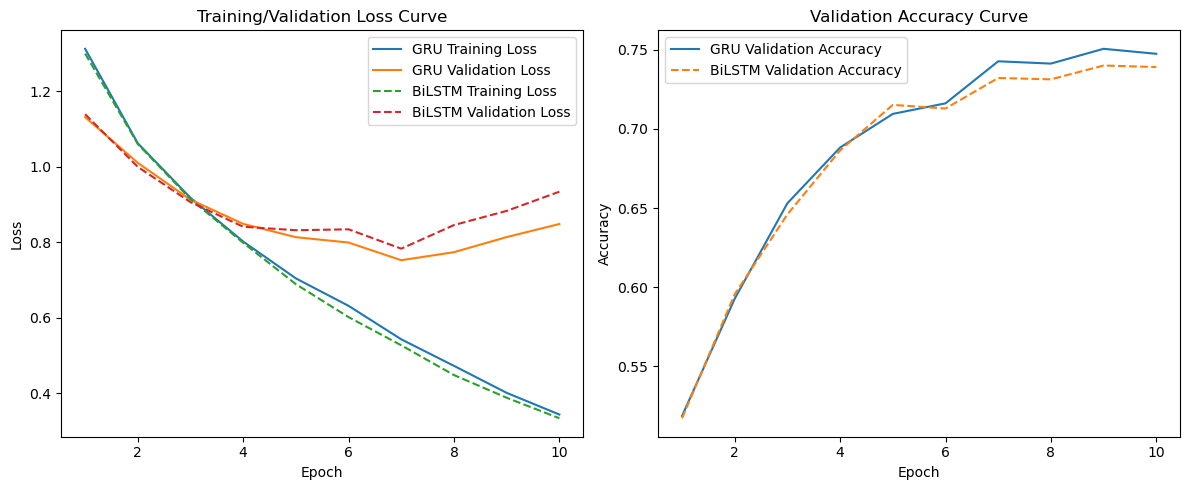


🎯 集成模型訓練完成，最佳模型參數已提供！


In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_gru)+1), train_losses_gru, label='GRU Training Loss')
plt.plot(range(1, len(val_losses_gru)+1), val_losses_gru, label='GRU Validation Loss')
plt.plot(range(1, len(train_losses_lstm)+1), train_losses_lstm, label='BiLSTM Training Loss', linestyle='--')
plt.plot(range(1, len(val_losses_lstm)+1), val_losses_lstm, label='BiLSTM Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss Curve')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies_gru)+1), val_accuracies_gru, label='GRU Validation Accuracy')
plt.plot(range(1, len(val_accuracies_lstm)+1), val_accuracies_lstm, label='BiLSTM Validation Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.savefig('ensemble_training_curves.png')
plt.show()

print("\n🎯 集成模型訓練完成，最佳模型參數已提供！")

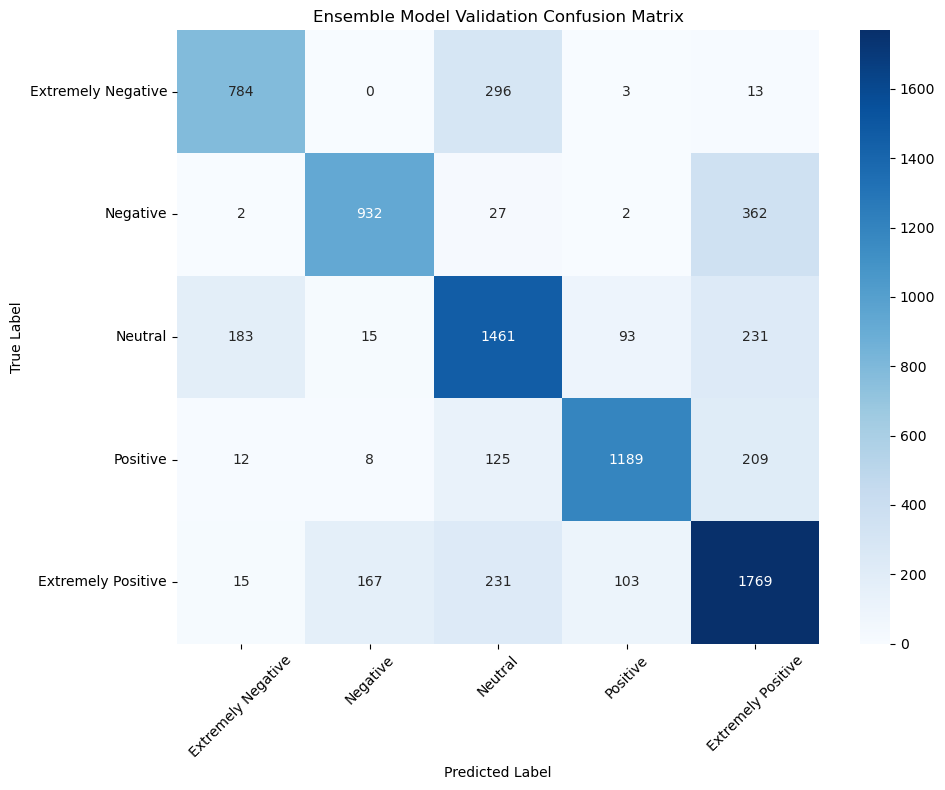

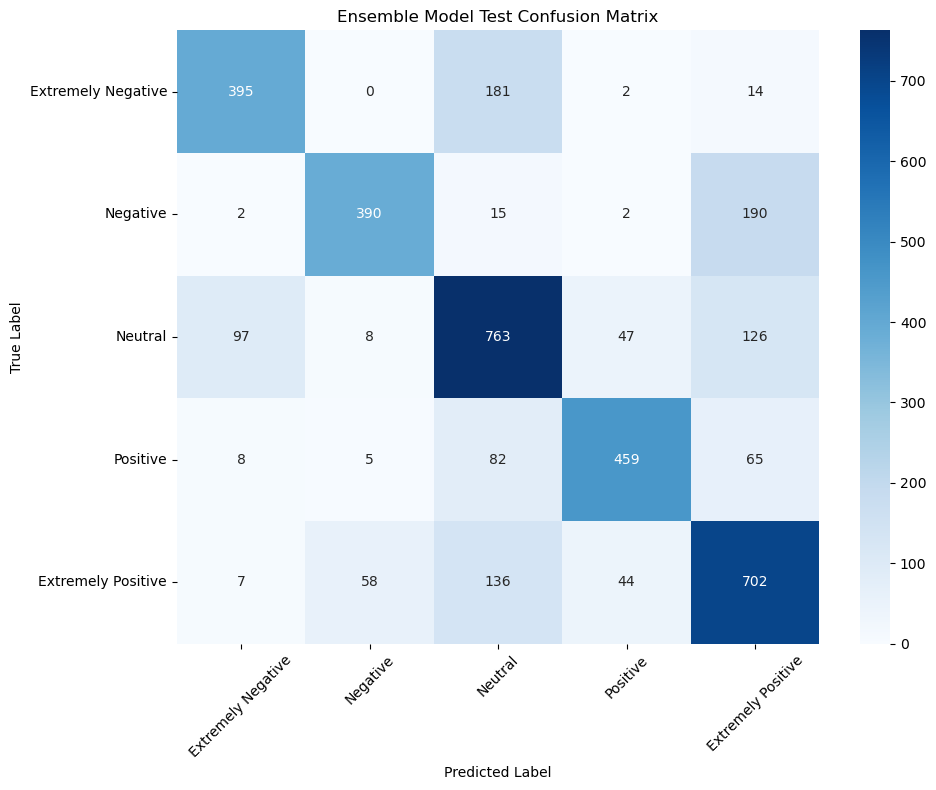


🎯 混淆矩陣已生成並保存！


In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 定義一個函數來生成混淆矩陣
def plot_confusion_matrix(model, loader, device, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 計算混淆矩陣
    cm = confusion_matrix(all_labels, all_preds)
    
    # 定義正確的類別順序
    class_order = ["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"]
    
    # 繪製混淆矩陣
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_order, yticklabels=class_order)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

# 創建 Ensemble 模型實例
ensemble_model = EnsembleClassifier(gru_model, lstm_model, weight_gru=weight_gru).to(device)

# 繪製驗證集的混淆矩陣
plot_confusion_matrix(ensemble_model, val_loader, device, title="Ensemble Model Validation Confusion Matrix")

# 繪製測試集的混淆矩陣
plot_confusion_matrix(ensemble_model, test_loader, device, title="Ensemble Model Test Confusion Matrix")

print("\n🎯 混淆矩陣已生成並保存！")

In [28]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.
